# IMPORTS

In [73]:
import pandas as pd
import numpy as np
import os
from decimal import Decimal
import pickle
from pathlib import Path

from sklearn import linear_model
import statsmodels.api as sm

import copy

import plotly.express as px
import plotly.graph_objects as go

# SETUP

In [2]:
dir_tree_util_path = os.path.join("utils", "dir_tree.py")
exec(open(dir_tree_util_path).read())

# INPUTS

In [3]:
# Paths
path_dados_trafego = PROJECT_DIRS["DADOS_TRAFEGO_AJUSTADOS_TRIMESTRAL_DIR"]
path_comercial = path_dados_trafego / 'df_VEQS_COMERCIAL_trimestral_saz_adjusted.parquet'
path_passeio = path_dados_trafego / 'df_VEQS_PASSEIO_trimestral_saz_adjusted.parquet'

path_dados_PIB = PROJECT_DIRS["DADOS_PIB_DIR"]
# path_output = TODO

In [4]:
periodicidade = 'Q'
periodos = [['2010Q2','2023Q4'], ['2016Q1','2023Q4']] # formato Y/M, inclusive

In [5]:
path_outputs = PROJECT_DIRS["DADOS_REGRESSAO_DIR"]

# CARREGANDO OS DADOS p/MEMORIA

In [6]:
df_veqs_comercial = pd.read_parquet(path_comercial)
df_veqs_passeio = pd.read_parquet(path_passeio)


dict_veqs_trafego = {'VEQS_COMERCIAL':df_veqs_comercial,
           'VEQS_PASSEIO':df_veqs_passeio}

In [7]:
dict_veqs_trafego['VEQS_COMERCIAL'].tail()

,AUTOPISTA FERNÃO DIAS,AUTOPISTA FLUMINENSE,AUTOPISTA LITORAL SUL,AUTOPISTA PLANALTO SUL,AUTOPISTA REGIS BITTENCOURT,CONCEBRA,CONCEPA,CONCER,CRO,CRT,...,ECOPONTE,ECOSUL,ECOVIAS DO CERRADO,MSVIA,NOVADUTRA,RODOVIA DO AÇO,TRANSBRASILIANA,VIA 040,VIA BAHIA,VIA SUL
trimestre,,,,,,,,,,,,,,,,,,,,,
2023Q2,2.849596e+07,6.049600e+06,2.344030e+07,5.965381e+06,3.252595e+07,1.611815e+07,NaN,2.835717e+06,2.545885e+07,NaN,...,1.076378e+06,4.708813e+06,6.883026e+06,1.103609e+07,NaN,3.273804e+06,4.073577e+06,1.470192e+07,1.661487e+07,1.342538e+07
2023Q3,2.886496e+07,6.063527e+06,2.443476e+07,5.706543e+06,3.275433e+07,1.658815e+07,NaN,2.843669e+06,2.586970e+07,NaN,...,1.085367e+06,5.186370e+06,7.452304e+06,1.150635e+07,NaN,3.257353e+06,4.182333e+06,1.459565e+07,1.626668e+07,1.370223e+07
2023Q4,2.975438e+07,6.317419e+06,2.461045e+07,6.340225e+06,3.312828e+07,1.639307e+07,NaN,2.915308e+06,2.672731e+07,NaN,...,1.092828e+06,5.536026e+06,7.661127e+06,1.212538e+07,NaN,3.196716e+06,4.022169e+06,1.492082e+07,1.508796e+07,1.391393e+07
2024Q1,NaN,4.963453e+06,2.203759e+07,6.495440e+06,NaN,1.668140e+07,NaN,2.685246e+06,2.078548e+07,NaN,...,9.631779e+05,4.908351e+06,6.657111e+06,1.135945e+07,NaN,3.060220e+06,1.350965e+06,1.287811e+07,1.640466e+07,7.693904e+06
2024Q2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Dados de PIB
df_pib_raw = pd.read_parquet(path_dados_PIB / 'PIB-Ipea-trimestral.parquet')

# Tratando os dados

## Funções

In [9]:
def remove_outliers(df_raw, col_dados, thresh=2.0):
    df = pd.DataFrame(index=df_raw.index)
    df['Dados_brutos'] = df_raw.dropna()
    df['mean'] = df['Dados_brutos'].mean()
    df['std'] = df['Dados_brutos'].std()
    df['dist_std_mean'] = (df['Dados_brutos'] - df['mean']) / df['std']
    
    # condition = abs(abs(df['dist_std_mean']) - thresh) > 1e-8
    condition = (abs(df['dist_std_mean']) - thresh) < 1e-8
    df = df.loc[condition]
    
    df[col_dados] = df['Dados_brutos']
    
    return df[col_dados]

## PIB

In [10]:
df_pib = df_pib_raw.copy()

In [11]:
# filtrando PIB para o periodo
df_pib = df_pib.loc[periodos[0][0] : periodos[0][1]]

In [12]:
len(df_pib)

55

In [13]:
# Removendo outliers do PIB
df_pib = remove_outliers(df_pib, 'PIB_real_pct', thresh=2.0)

In [14]:
len(df_pib)

53

## Trafego

In [15]:
dict_veqs = copy.deepcopy(dict_veqs_trafego)

In [16]:
# trocando zeros para NaN
for veq, df in dict_veqs.items():
    for col in df:
        df[col] = df[col].apply(lambda x: x if (abs(x) > 1e-8) else None)

In [17]:
# Convertendo os dados para variação relativa em pct (=PIB)
for veq, df in dict_veqs.items():
    for col in df:
        df[col] = df[col].dropna().pct_change().replace([np.inf, -np.inf], None) * 100

In [18]:
# retirando outliers
for veq, df in dict_veqs.items():
    for col in df:
        len1 = len(df[col].dropna())
        df[col] = remove_outliers(df[col], col, thresh=2.0)
        len2 = len(df[col].dropna())
        print(len2-len1, veq, col) 
        # OBS: outliers ficam como NaN

-5 VEQS_COMERCIAL AUTOPISTA FERNÃO DIAS
-2 VEQS_COMERCIAL AUTOPISTA FLUMINENSE
-4 VEQS_COMERCIAL AUTOPISTA LITORAL SUL
-3 VEQS_COMERCIAL AUTOPISTA PLANALTO SUL
-2 VEQS_COMERCIAL AUTOPISTA REGIS BITTENCOURT
-1 VEQS_COMERCIAL CONCEBRA
-1 VEQS_COMERCIAL CONCEPA
-3 VEQS_COMERCIAL CONCER
-3 VEQS_COMERCIAL CRO
-2 VEQS_COMERCIAL CRT
-3 VEQS_COMERCIAL ECO050
-2 VEQS_COMERCIAL ECO101 CONCESSIONARIA DE RODOVIAS S/A
-2 VEQS_COMERCIAL ECOPONTE
-4 VEQS_COMERCIAL ECOSUL
0 VEQS_COMERCIAL ECOVIAS DO CERRADO
-1 VEQS_COMERCIAL MSVIA
-3 VEQS_COMERCIAL NOVADUTRA
-4 VEQS_COMERCIAL RODOVIA DO AÇO
-1 VEQS_COMERCIAL TRANSBRASILIANA
-3 VEQS_COMERCIAL VIA 040
-2 VEQS_COMERCIAL VIA BAHIA
-1 VEQS_COMERCIAL VIA SUL
-3 VEQS_PASSEIO AUTOPISTA FERNÃO DIAS
-3 VEQS_PASSEIO AUTOPISTA FLUMINENSE
-5 VEQS_PASSEIO AUTOPISTA LITORAL SUL
-3 VEQS_PASSEIO AUTOPISTA PLANALTO SUL
-4 VEQS_PASSEIO AUTOPISTA REGIS BITTENCOURT
-3 VEQS_PASSEIO CONCEBRA
-2 VEQS_PASSEIO CONCEPA
-2 VEQS_PASSEIO CONCER
-3 VEQS_PASSEIO CRO
-3 VEQS_PASSEIO 

# FUNCÕES

In [19]:
def make_base_train(df_y, df_X, periodo:list, drop_inverted, drop_X_negatives):  
    
    if drop_X_negatives:
        df_X = df_X.loc[df_X > 1e-8]
    
    df_train = pd.merge(df_y, df_X, how='inner', left_index=True, right_index=True)
    df_train = df_train.dropna(how='any')
    df_train = df_train.loc[periodo[0]:periodo[1]]  
    
    # print(df_train.index[0])
    # print(pd.to_datetime(periodo[0]).to_period('Q'))
    # print(df_train.index[0] > pd.to_datetime(periodo[0]).to_period('Q'))
    
    if df_train.index[0] > pd.to_datetime(periodo[0]).to_period('Q'):
        return None
    
    if drop_inverted:
        df_train['rows_drop'] = df_train.iloc[:,0] * df_train.iloc[:,1]
        df_train = df_train.loc[df_train['rows_drop'] > 0]
        df_train = df_train.drop(columns=['rows_drop'])
    
    return df_train

In [20]:
def regressao(df_train, conc, col_X, fit_intercept):
    y_train = df_train[conc]
    X_train = df_train[col_X]
    if fit_intercept:
        X_train = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train).fit()
    return model

In [21]:
# def regressao(y_train, X_train, fit_intercept=False):
#     if fit_intercept:
#         X_train = sm.add_constant(X_train)
#     model = sm.OLS(y_train, X_train).fit()
#     return model

In [22]:
def regression_results(df_train, conc, col_X, fit_intercept):
    model = regressao(df_train, conc, col_X, fit_intercept=fit_intercept)
    
    df_results = pd.DataFrame()
    
    df_results.loc[conc, 'coeficiente'] = model.params.iloc[0]
    df_results.loc[conc, 'R2'] = model.rsquared
    df_results.loc[conc, 'p-valor_pct'] = model.pvalues.iloc[0]
    df_results.loc[conc, 'n'] = len(df_train)
    df_results.loc[conc, 'periodo_inicial'] = df_train.index[0]
    df_results.loc[conc, 'periodo_final'] = df_train.index[-1]

    return df_results

# REGRESSÃO

In [23]:
# sbx = make_base_train(dict_veqs['VEQS_COMERCIAL']['AUTOPISTA FERNÃO DIAS'], df_pib, periodos[0], drop_inverted=True)
# sbx

In [24]:
# sbx_regr = regressao(sbx['AUTOPISTA FERNÃO DIAS'], sbx['PIB_real_pct'])

In [25]:
# sbx_regr.df_resid

In [26]:
# sbx = make_base_train(dict_veqs['VEQS_COMERCIAL']['CRO'], df_pib, periodos[1], drop_inverted=True)
# sbx

## Funções

In [27]:
def make_regressions(dict_veqs, df_pib, periodo, drop_inverted, drop_X_negatives, fit_intercept):
    dict_results = {veq:None for veq in dict_veqs}
    for veq, df in dict_veqs.items():
        df_results = pd.DataFrame()
        for conc in df:
            df_train = make_base_train(dict_veqs[veq][conc], df_pib, periodo, drop_inverted=drop_inverted, drop_X_negatives=drop_X_negatives)
            if df_train is not None:
                # print(f'{conc}_{veq}: há dados')
                df_conc_results = regression_results(df_train, conc, df_pib.name, fit_intercept=fit_intercept)
                # new_index = [df_conc_results.index[0] + f'_{veq}']
                # df_conc_results.index = new_index
                df_results = pd.concat([df_results, df_conc_results])
            else:
                ...
        dict_results[veq] = df_results
                # print(f'{conc}_{veq}: não há dados para o período')
    return dict_results

## Periodo 1

In [28]:
periodo = periodos[0]
dict_results_per1 = make_regressions(dict_veqs, df_pib, periodo, 
                                   drop_inverted=True, drop_X_negatives=False, fit_intercept=False)
dict_results_per1['VEQS_PASSEIO']

,coeficiente,R2,p-valor_pct,n,periodo_inicial,periodo_final
AUTOPISTA FERNÃO DIAS,1.003998,0.514616,5.586183e-06,30.0,2010Q2,2023Q4
AUTOPISTA FLUMINENSE,0.586451,0.603908,1.689263e-07,31.0,2010Q3,2023Q4
AUTOPISTA LITORAL SUL,0.832137,0.495860,1.408700e-05,29.0,2010Q2,2023Q2
AUTOPISTA PLANALTO SUL,0.681757,0.598366,1.385810e-06,27.0,2010Q2,2023Q1
AUTOPISTA REGIS BITTENCOURT,0.710692,0.468038,3.065218e-05,29.0,2010Q2,2023Q4
CONCEPA,0.899511,0.614457,4.324247e-05,19.0,2010Q3,2018Q1
CONCER,0.772736,0.442316,2.418779e-05,32.0,2010Q3,2023Q4
CRT,0.617606,0.523836,4.328195e-05,24.0,2010Q2,2022Q2
ECOSUL,0.828151,0.488090,1.237026e-05,30.0,2010Q2,2023Q4
RODOVIA DO AÇO,0.539092,0.338686,1.450378e-03,26.0,2010Q2,2023Q1


In [29]:
dict_results_per1['VEQS_COMERCIAL']

,coeficiente,R2,p-valor_pct,n,periodo_inicial,periodo_final
AUTOPISTA FERNÃO DIAS,0.785451,0.664975,4.047056e-08,29.0,2010Q2,2023Q4
AUTOPISTA FLUMINENSE,0.810266,0.520453,2.167843e-06,32.0,2010Q2,2023Q4
AUTOPISTA LITORAL SUL,0.930129,0.430909,4.506532e-05,31.0,2010Q2,2023Q4
AUTOPISTA PLANALTO SUL,0.879425,0.344103,3.334367e-04,32.0,2010Q2,2023Q4
AUTOPISTA REGIS BITTENCOURT,0.592517,0.476560,3.178849e-06,35.0,2010Q2,2023Q4
CONCEPA,0.648694,0.550661,3.310616e-05,23.0,2010Q4,2018Q1
CONCER,0.769595,0.562526,2.142103e-07,34.0,2010Q2,2023Q4
CRT,0.727977,0.500990,1.749508e-05,28.0,2010Q2,2022Q2
ECOSUL,1.662836,0.543647,1.482003e-06,31.0,2010Q2,2023Q4
RODOVIA DO AÇO,1.068407,0.580133,6.187203e-06,25.0,2010Q2,2023Q2


## Periodo 2

In [30]:
periodo = periodos[1]
dict_results_per2 = make_regressions(dict_veqs, df_pib, periodo, 
                                   drop_inverted=True, drop_X_negatives=False, fit_intercept=False)
dict_results_per2['VEQS_PASSEIO']

,coeficiente,R2,p-valor_pct,n,periodo_inicial,periodo_final
AUTOPISTA FERNÃO DIAS,0.748843,0.484292,0.001339,17.0,2016Q1,2023Q4
AUTOPISTA FLUMINENSE,0.738374,0.699427,0.000029,16.0,2016Q1,2023Q4
AUTOPISTA LITORAL SUL,1.270308,0.573408,0.000432,16.0,2016Q2,2023Q2
AUTOPISTA PLANALTO SUL,0.836608,0.572773,0.000689,15.0,2016Q2,2023Q1
AUTOPISTA REGIS BITTENCOURT,1.147444,0.534485,0.001292,15.0,2016Q2,2023Q4
CONCEBRA,0.733186,0.691771,0.000065,15.0,2016Q1,2023Q2
CONCEPA,1.472859,0.233549,0.516731,3.0,2016Q4,2018Q1
CONCER,1.159359,0.684483,0.000042,16.0,2016Q1,2023Q4
CRO,0.784317,0.418944,0.003687,17.0,2016Q1,2023Q4
CRT,0.719940,0.616813,0.004177,10.0,2016Q1,2022Q2


In [31]:
dict_results_per2['VEQS_COMERCIAL']

,coeficiente,R2,p-valor_pct,n,periodo_inicial,periodo_final
AUTOPISTA FERNÃO DIAS,0.629738,0.512411,0.001818,15.0,2016Q1,2023Q4
AUTOPISTA FLUMINENSE,1.043675,0.527687,0.000428,18.0,2016Q1,2023Q4
AUTOPISTA LITORAL SUL,1.111588,0.446528,0.001765,18.0,2016Q1,2023Q4
AUTOPISTA PLANALTO SUL,1.123234,0.382858,0.008095,16.0,2016Q3,2023Q4
AUTOPISTA REGIS BITTENCOURT,0.625364,0.371972,0.003329,20.0,2016Q2,2023Q4
CONCEBRA,0.694911,0.528757,0.002128,14.0,2016Q1,2023Q3
CONCEPA,0.911626,0.480420,0.056641,7.0,2016Q2,2018Q1
CONCER,0.756523,0.591522,0.000308,16.0,2016Q1,2023Q4
CRO,1.443333,0.396190,0.003881,18.0,2016Q1,2023Q4
CRT,1.039326,0.576584,0.000645,15.0,2016Q1,2022Q2


# Dict com os resultados, para plot e exportação

## Funções

In [87]:
def make_regression_curves(dict_veqs, df_pib, periodo, periciodidade, drop_inverted, drop_X_negatives, fit_intercept):
    # dict_curves = {f'{veq}_{conc}':None for veq, df in dict_veqs.items() for conc in df}
    # dict_curves = {veq:conc for veq, df in dict_veqs.items() for conc in df}
    dict_curves = {veq:{conc:None for conc in df} for veq, df in dict_veqs.items()}
    dict_results = make_regressions(dict_veqs, df_pib, periodo, 
                                   drop_inverted=drop_inverted, drop_X_negatives=drop_X_negatives, fit_intercept=fit_intercept)
    for veq, df in dict_veqs.items():   
        for conc in df: 
            df_train = make_base_train(dict_veqs[veq][conc], df_pib, periodo, drop_inverted=drop_inverted, drop_X_negatives=drop_X_negatives)
            if df_train is not None:
                periodo_inicial = pd.to_datetime(periodo[0]).to_period(periodicidade) - 1
                periodo_final = pd.to_datetime(periodo[1]).to_period(periodicidade)
                index = dict_veqs_trafego[veq][conc].dropna().index
                df_curves = pd.DataFrame(index=index)
                
                df_curves = df_curves.join(dict_veqs_trafego[veq][conc].dropna())
                df_curves = df_curves.loc[periodo_inicial:periodo_final]
                
                df_curves['delta_trafego_pct'] = df_curves[conc].pct_change()*100
                df_curves['pib_real_pct'] = df_pib_raw
                df_curves['elasticidade'] = dict_results[veq].loc[conc,'coeficiente']
                df_curves['fit_pct'] = df_curves['pib_real_pct'] * df_curves['elasticidade']
             
                dict_curves[veq][conc] = df_curves.iloc[1:,:]

    return dict_curves

In [88]:
# def make_regression_curves(dict_veqs, df_pib, periodo, periciodidade, drop_inverted, drop_X_negatives, fit_intercept):
#     # dict_curves = {f'{veq}_{conc}':None for veq, df in dict_veqs.items() for conc in df}
#     # dict_curves = {veq:conc for veq, df in dict_veqs.items() for conc in df}
#     dict_curves = {veq:{conc:None for conc in df} for veq, df in dict_veqs.items()}
#     dict_results = make_regressions(dict_veqs, df_pib, periodo, 
#                                    drop_inverted=drop_inverted, drop_X_negatives=drop_X_negatives, fit_intercept=fit_intercept)
#     for veq, df in dict_veqs.items():   
#         for conc in df: 
#             df_train = make_base_train(dict_veqs[veq][conc], df_pib, periodo, drop_inverted=drop_inverted, drop_X_negatives=drop_X_negatives)
#             if df_train is not None:
#                 periodo_inicial = pd.to_datetime(periodo[0]).to_period(periodicidade) - 1
#                 periodo_final = pd.to_datetime(periodo[1]).to_period(periodicidade)
#                 index = dict_veqs_trafego[veq][conc].dropna().index
#                 df_curves = pd.DataFrame(index=index)
                
#                 df_curves = df_curves.join(dict_veqs_trafego[veq][conc].dropna())
#                 df_curves = df_curves.loc[periodo_inicial:periodo_final]
                
#                 df_curves['pib_real_pct'] = df_pib_raw
#                 df_curves['elasticidade'] = dict_results[veq].loc[conc,'coeficiente']
#                 df_curves['trafego_fit_pct'] =  df_curves['pib_real_pct'] *  df_curves['elasticidade']
#                 df_curves['trafego_fit_mult'] = 1 + df_curves['trafego_fit_pct']/100
#                 df_curves.loc[df_curves.index[0], 'trafego_fit_mult'] = 1
#                 df_curves['trafego_fit_cumprod'] = df_curves['trafego_fit_mult'].cumprod()

#                 df_curves['trafego_fit'] = df_curves.loc[periodo_inicial, conc] * df_curves['trafego_fit_cumprod']
#                 df_curves['residuos'] = df_curves.loc[:,conc] - df_curves['trafego_fit']

                
# #                 df_curves['elasticidade'] = dict_results[veq].loc[conc,'coeficiente']
# #                 # print(veq, conc, dict_results[veq].loc[conc,'coeficiente'])
# #                 df_curves['trafego_fit_pct'] =  df_curves['pib_real_pct'] *  df_curves['elasticidade']
# #                 df_curves['trafego_fit_mult'] = 1 + df_curves['trafego_fit_pct']/100
# #                 df_curves.loc[df_curves.index[0], 'trafego_fit_mult'] = 1
# #                 df_curves['trafego_fit_cumprod'] = df_curves['trafego_fit_mult'].cumprod()
                
# #                 df_curves['trafego_fit'] = df_curves.loc[periodo_inicial, conc] * df_curves['trafego_fit_cumprod']
# #                 df_curves['residuos'] = df_curves.loc[:,conc] - df_curves['trafego_fit']
                
#                 dict_curves[veq][conc] = df_curves

#     return dict_curves

## Período 1

In [89]:
periodo = periodos[0]
dict_curves_p1 = make_regression_curves(dict_veqs, df_pib, periodo, periodicidade,
                                        drop_inverted=True, drop_X_negatives=False, fit_intercept=False)
dict_curves_p1['VEQS_COMERCIAL']['AUTOPISTA FERNÃO DIAS']

,AUTOPISTA FERNÃO DIAS,delta_trafego_pct,pib_real_pct,elasticidade,fit_pct
trimestre,,,,,
2010Q2,2.202874e+07,8.703506,8.52,0.785451,6.692042
2010Q3,2.336369e+07,6.060054,6.91,0.785451,5.427466
2010Q4,2.655924e+07,13.677392,5.69,0.785451,4.469216
2011Q1,2.730935e+07,2.824283,5.20,0.785451,4.084345
2011Q2,2.753984e+07,0.843995,4.70,0.785451,3.691619
2011Q3,2.831516e+07,2.815287,3.54,0.785451,2.780496
2011Q4,2.816863e+07,-0.517499,2.57,0.785451,2.018609
2012Q1,2.920709e+07,3.686592,1.71,0.785451,1.343121
2012Q2,2.861656e+07,-2.021875,0.99,0.785451,0.777596


# Período 2 

In [90]:
periodo = periodos[1]
dict_curves_p2 = make_regression_curves(dict_veqs, df_pib, periodo, periodicidade,
                                        drop_inverted=True, drop_X_negatives=False, fit_intercept=False)
dict_curves_p2['VEQS_COMERCIAL']['CRO']

,CRO,delta_trafego_pct,pib_real_pct,elasticidade,fit_pct
trimestre,,,,,
2016Q1,2.180115e+07,-3.131261,-5.14,1.443333,-7.418734
2016Q2,2.071084e+07,-5.001140,-3.22,1.443333,-4.647534
2016Q3,1.968716e+07,-4.942743,-2.45,1.443333,-3.536167
2016Q4,1.587792e+07,-19.348835,-2.26,1.443333,-3.261934
2017Q1,1.876749e+07,18.198638,0.28,1.443333,0.404133
2017Q2,1.796686e+07,-4.266051,0.79,1.443333,1.140233
2017Q3,1.830011e+07,1.854803,1.64,1.443333,2.367067
2017Q4,2.093139e+07,14.378526,2.58,1.443333,3.723800
2018Q1,2.013491e+07,-3.805196,1.90,1.443333,2.742334


# Plots das regressões


In [38]:
dict_curves_p2['VEQS_COMERCIAL']['CRO'].index

PeriodIndex(['2015Q4', '2016Q1', '2016Q2', '2016Q3', '2016Q4', '2017Q1',
             '2017Q2', '2017Q3', '2017Q4', '2018Q1', '2018Q2', '2018Q3',
             '2018Q4', '2019Q1', '2019Q2', '2019Q3', '2019Q4', '2020Q1',
             '2020Q2', '2020Q3', '2020Q4', '2021Q1', '2021Q2', '2021Q3',
             '2021Q4', '2022Q1', '2022Q2', '2022Q3', '2022Q4', '2023Q1',
             '2023Q2', '2023Q3', '2023Q4'],
            dtype='period[Q-DEC]', name='trimestre')

In [107]:
def make_plot(df_curves, veq, conc):
    df_plot = df_curves.iloc[1:,:].copy()
    df_plot.index = df_plot.index.to_timestamp(how='end')
    
    X = df_plot['pib_real_pct']
    
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(
    x=X, y=df_plot['delta_trafego_pct'],
    mode='markers',
    name='Observed Data'
    ))
    
    fig.add_trace(go.Scatter(
    x=X, y=df_plot['fit_pct'],
    mode='lines',
    name='Fitted line'
    ))
    
    fig.update_layout(
    title=f"Regressão {conc}_{veq}",
    xaxis_title="delta PIB real",
    yaxis_title="delta tráfego"
    )
    
    fig.show()

In [108]:
# def make_plot(df_curves, conc):
#     df_plot = df_curves.iloc[1:,:].copy()
#     df_plot.index = df_plot.index.to_timestamp(how='end')
    
#     X_axis = df_plot.index
#     fig = px.line(df_plot, x=X_axis, y=df_plot['trafego_fit'], labels={'y': 'Values'})
#     fig.add_scatter(x=X_axis, y=df_plot[conc], mode='markers', name='efetivo')
    
    
    
#     fig.show()

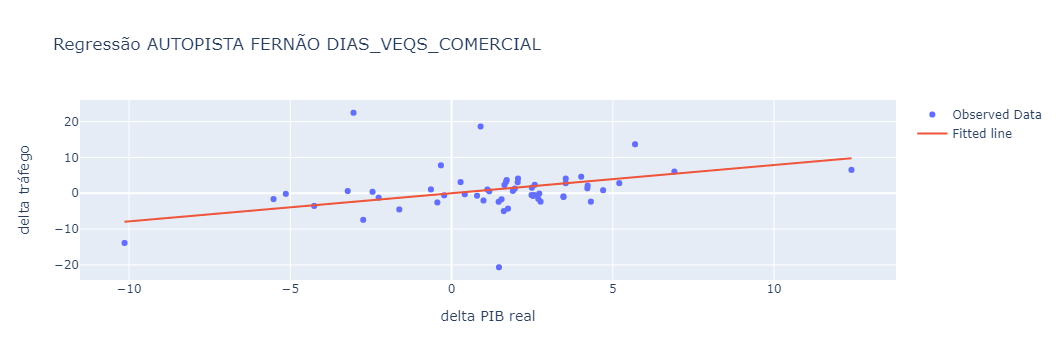

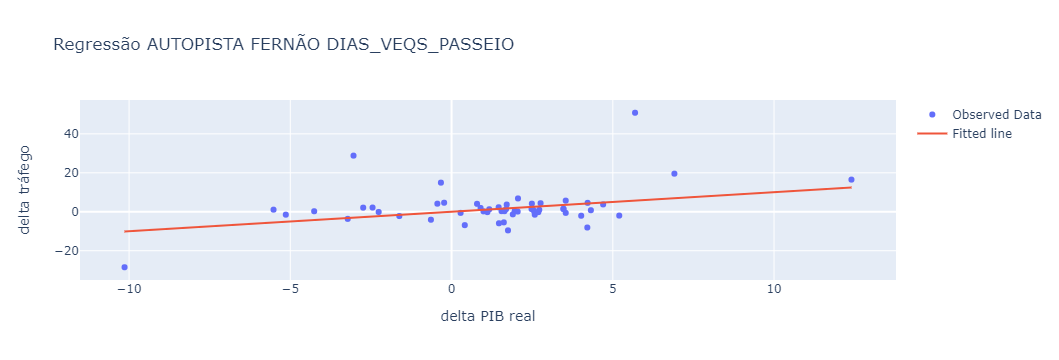

In [110]:
for veq, _dict in dict_curves_p1.items():
    for conc in _dict:
        make_plot(_dict[conc], veq, conc)
        break

# Salvando para excel

In [82]:
with pd.ExcelWriter(path_outputs / 'resultado_modelos_PIB_mensal.xlsx') as writer:
    # df_resultados = pd.DataFrame(index=df_periodos.index)
    for p in periodos:
        for key, veq in dict_veqs.items():
            df_resultados = make_models(veq, df_periodos, df_PIB, p, fit_intercept=False)
            sheet_name = f'{p[0]}-{p[1]}-{key}_mensal'
            df_resultados.to_excel(writer, sheet_name = sheet_name)        

/home/andcm/.cache/pypoetry/virtualenvs/infra-data-J9p6eQia-py3.9/lib/python3.9/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")
/home/andcm/.cache/pypoetry/virtualenvs/infra-data-J9p6eQia-py3.9/lib/python3.9/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")
/home/andcm/.cache/pypoetry/virtualenvs/infra-data-J9p6eQia-py3.9/lib/python3.9/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")
/home/andcm/.cache/